## Installing The Libraries

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import yfinance as yf

## Reading The Data

Current Stocks:
- Reliance
- Maruti
- ICICI Bank
- Bharti Airtel
- ITC

Time Frame:
2015-01-01 to 2019-12-31

In [31]:
df = data.DataReader(['RELIANCE.NS', 'MARUTI.NS', 'ICICIBANK.NS', 'BHARTIARTL.NS', 'ITC.NS'], 'yahoo', start='2015/01/01', end='2019/12/31')
df = df['Adj Close']
df.head()

Symbols,RELIANCE.NS,MARUTI.NS,ICICIBANK.NS,BHARTIARTL.NS,ITC.NS
Date,,,,,
2015-01-01,419.247375,3115.939209,299.031525,321.347198,204.595123
2015-01-02,418.137726,3133.520996,307.519562,323.251038,205.235992
2015-01-05,413.557587,3215.785889,308.156097,316.078491,206.044006
2015-01-06,394.788483,3166.771973,295.084564,313.599091,200.750107
2015-01-07,403.382172,3206.411621,287.105957,314.351807,197.016510


In [12]:
# Log of percentage change
#because log of percentage change is time additive
#add 1+x to avoid log(0) error

#Compute covariance matrix
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

Symbols,RELIANCE.NS,MARUTI.NS,ICICIBANK.NS,BHARTIARTL.NS,ITC.NS
Symbols,,,,,
RELIANCE.NS,0.000261,0.000075,0.000092,0.000078,0.000045
MARUTI.NS,0.000075,0.000254,0.000112,0.000064,0.000056
ICICIBANK.NS,0.000092,0.000112,0.000384,0.000079,0.000074
BHARTIARTL.NS,0.000078,0.000064,0.000079,0.000393,0.000049
ITC.NS,0.000045,0.000056,0.000074,0.000049,0.000239


In [13]:
#compute correlation matrix
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

Symbols,RELIANCE.NS,MARUTI.NS,ICICIBANK.NS,BHARTIARTL.NS,ITC.NS
Symbols,,,,,
RELIANCE.NS,1.000000,0.292521,0.290284,0.242204,0.180280
MARUTI.NS,0.292521,1.000000,0.358931,0.201616,0.227887
ICICIBANK.NS,0.290284,0.358931,1.000000,0.203290,0.242818
BHARTIARTL.NS,0.242204,0.201616,0.203290,1.000000,0.161020
ITC.NS,0.180280,0.227887,0.242818,0.161020,1.000000


In [14]:
# Yearly returns for individual companies
ind_er = df.resample('Y').last().pct_change().mean()
ind_er

Symbols
RELIANCE.NS      0.343729
MARUTI.NS        0.197000
ICICIBANK.NS     0.257279
BHARTIARTL.NS    0.207390
ITC.NS           0.042065
dtype: float64

In [17]:
# Portfolio returns
w = [0.1, 0.2, 0.4, 0.15, 0.15]
port_er = (w*ind_er).sum()
port_er

0.21410279275518818

In [18]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

Symbols
RELIANCE.NS      0.255397
MARUTI.NS        0.251962
ICICIBANK.NS     0.310037
BHARTIARTL.NS    0.313250
ITC.NS           0.244330
dtype: float64

In [19]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Symbols,,
RELIANCE.NS,0.343729,0.255397
MARUTI.NS,0.197000,0.251962
ICICIBANK.NS,0.257279,0.310037
BHARTIARTL.NS,0.207390,0.313250
ITC.NS,0.042065,0.244330


In [20]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000

In [21]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [22]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [23]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,RELIANCE.NS weight,MARUTI.NS weight,ICICIBANK.NS weight,BHARTIARTL.NS weight,ITC.NS weight
0,0.137086,0.177721,0.046425,0.306402,0.091975,0.083165,0.472033
1,0.208734,0.174377,0.243725,0.103450,0.245277,0.147172,0.260375
2,0.203710,0.186358,0.084035,0.158694,0.302965,0.281295,0.173011
3,0.181916,0.197609,0.070804,0.088917,0.435892,0.065961,0.338426
4,0.238651,0.180868,0.336338,0.062429,0.237830,0.207275,0.156129


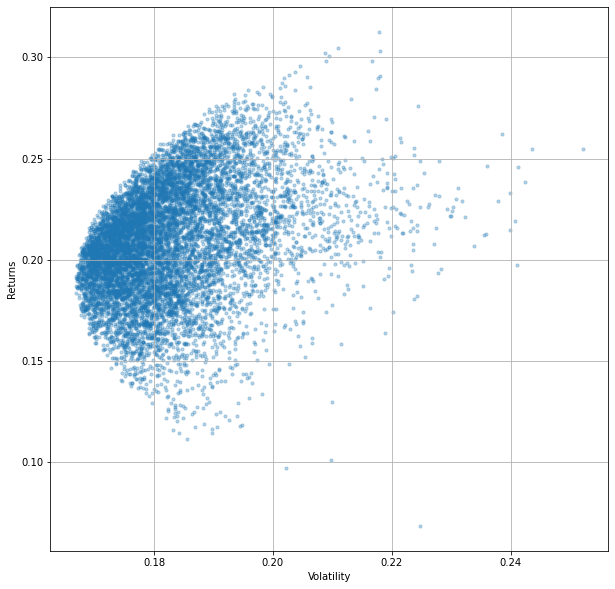

In [26]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.show()

In [27]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns                 0.190750
Volatility              0.166841
RELIANCE.NS weight      0.230850
MARUTI.NS weight        0.222373
ICICIBANK.NS weight     0.084530
BHARTIARTL.NS weight    0.159691
ITC.NS weight           0.302557
Name: 9805, dtype: float64

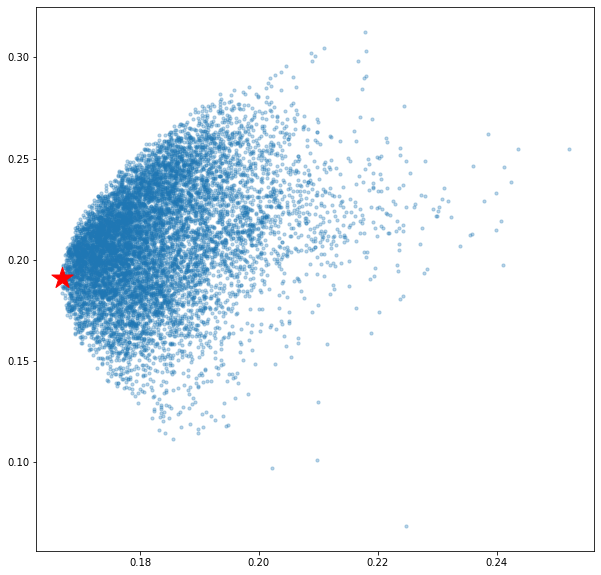

In [28]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

In [29]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns                 0.281756
Volatility              0.193537
RELIANCE.NS weight      0.547864
MARUTI.NS weight        0.122720
ICICIBANK.NS weight     0.171033
BHARTIARTL.NS weight    0.112496
ITC.NS weight           0.045887
Name: 4309, dtype: float64

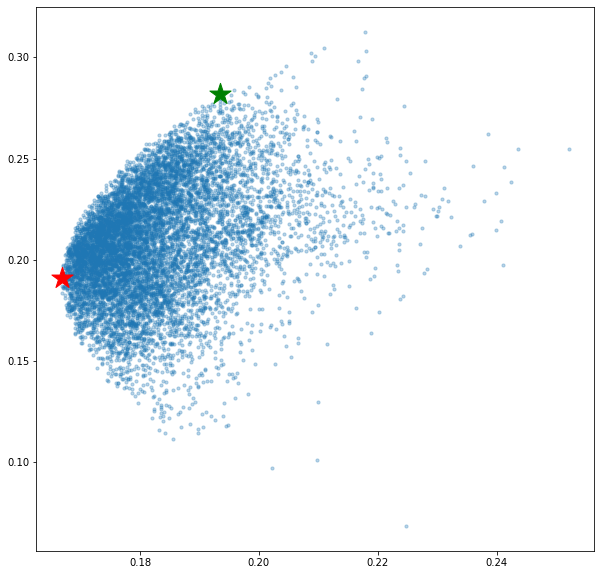

In [30]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)